# Quran Reciter Identification (Speech Recognition) using Machine Learning
#### by Muhammad Khurram Chughtai

# 1_Data_Download
This notebook looks at some statistics on the downloaded data. It also discusses what audio data looks like to computers, shows audio data stats for few reciters, and visualizes audio data & features of interest.

References:
- The audio data was downloaded from this website: https://everyayah.com/data/status.ph
- The Quran Surah/Aya info was obtained from tanzil.net: http://tanzil.net/res/text/metadata/quran-data.xml 
- Audio feature descriptions from: https://levelup.gitconnected.com/audio-data-analysis-using-deep-learning-part-1-7f6e08803f60


# Quran organization
Before looking at the downloaded data, it is important to understand how Quran is organized and some related terms which will help make sense of the data.

Quran is the holy book of religion of Islam. It is organized as follows:
- Quran is dvided into "suras" (chapters) with unque names for each sura. e.g. the first sura has the name "Al-Fatiha" (The Opening). There are 114 suras.
- Each "sura" (chapter) consists of at least 3 or more "ayas" (verses). Each "aya" (verse) consists of one or more Arabic sentences. e.g. the first surah "Al-Fatiha" consists of 7 ayas. There are total of 6,236 ayas in all 114 suras.


# Audio
Audio or sound is represented as a signal with parameters such as time, amplitude, frequency, etc. An audio signal can be expressed as a function of time with Amplitude in "time domain" or Frequency in the "frequency domain"

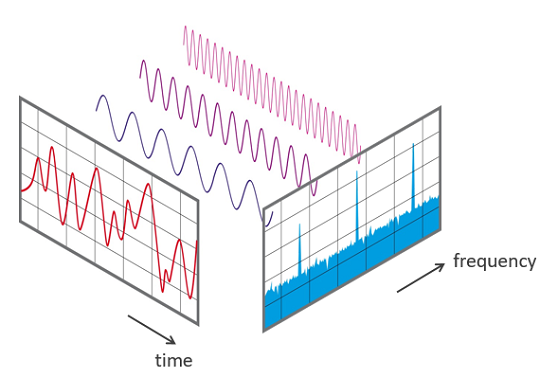
Source: https://commons.wikimedia.org/wiki/File:FFT-Time-Frequency-View.png


# Digital Audio
Digital audio is sound recorded in or encoded into digital form. Sound waves are inherently analog in nature so the process of digitization is "digitally approximating" the sound waves. The analog-to-digital process results in some loss in quality which can be reduced but can never be zero. This process works by taking sound wave samples many times a second with each sample as a number. E.g. for CDs samples are taken 44100 times per second (44.1kHz) each with 16 bit sample depth.

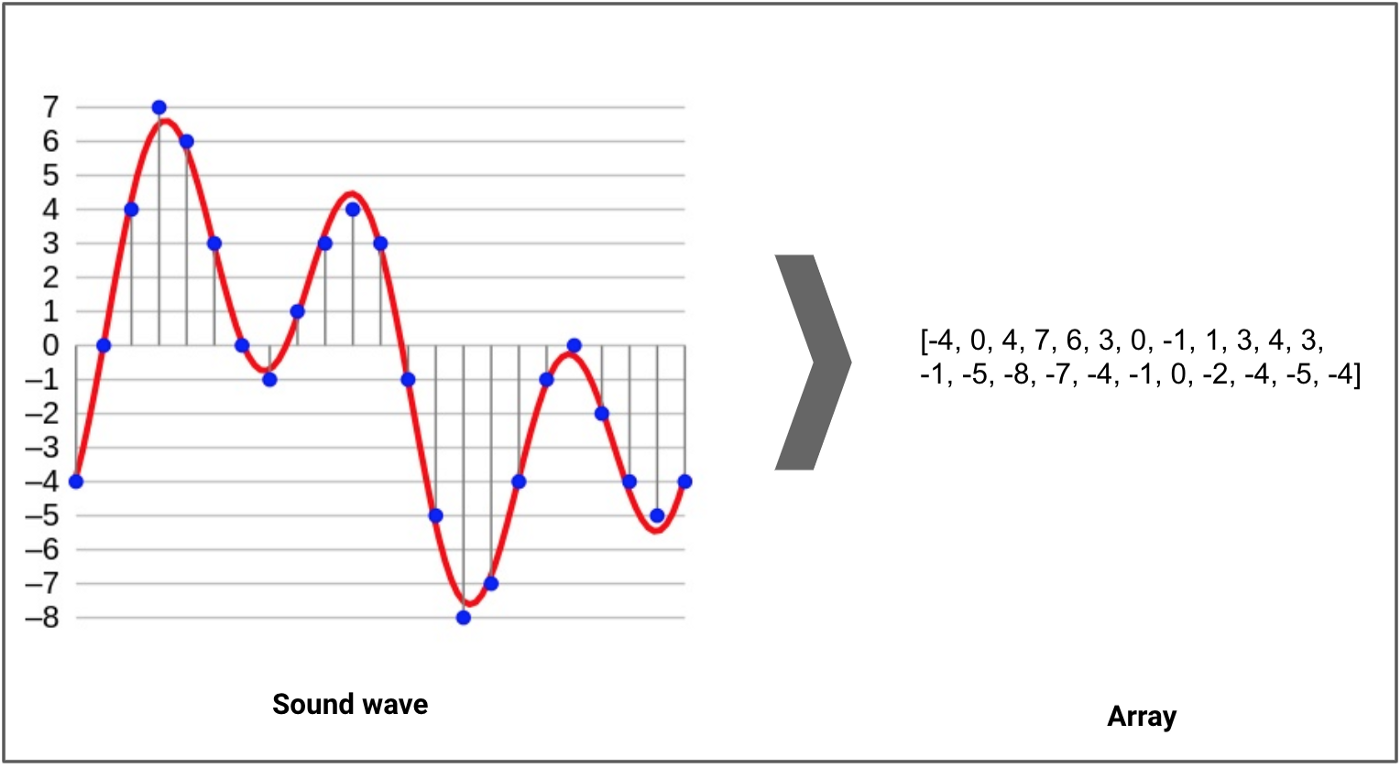
A sound wave, in red, represented digitally, in blue (after sampling and 4-bit quantisation), with the resulting array shown on the right. Original © Aquegg | Wikimedia Commons

There are many popular digital audio formats:

- MP3 format
- WMA (Windows Media Audio) format
- WAV (Waveform Audio File) format

We will be using the MP3 format for this project.

Let's start by loading all the helper procedures into the Notebook.
Loading helper procedures from helpers.py:
- Create a new cell & execute the following line
        %load helpers.py
- This will put the contents of the file in the cell. Then execute the cell to load everything in memory

**Note**: Start by cutting the cell below to replace it with empty new cell

In [2]:
# %load helpers.py
##################
# imports
import os
import csv
import re
import pathlib
import xml.etree.ElementTree as ET
import zipfile
import shutil
import librosa
import math
import numpy as np 
import pandas as pd 
import warnings
import audioread
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import ExcelWriter
from pydub.utils import mediainfo

##################
# Default Constants
# Directory where MP3 files have been downloaded
zip_data_dir   = '../DownloadedReciters'
# Name of ZIP file for each reciter
zip_file_name  = '000_versebyverse.zip'
# Directory where processed data & other generated data will be stored
data_dir       = '../data'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
quran_meta_xml = os.path.join(os.getcwd(), 'Qurandata', "quran-data.xml")
# Max/Min number of Sura/Aya with first as index 1
SuraIndexMIN   = 1
SuraIndexMAX   = 114
AyaIndexMIN    = 0
AyaIndexMAX    = 6236

# Suppress this warning from librosa:
# UserWarning: PySoundFile failed. Trying audioread instead.
warnings.filterwarnings('ignore')

##################
# Functions
def qsura_ayat_to_labels(suraFrom=None, suraTo=None, ayaFrom=None, ayaTo=None):
    """ Converts either Sura or Aya numbers to labels.

       :param suraFrom: An interger for Sura index to start from. Valid numbers are 1 to 114 (default: None)
       :type suraFrom: int
       :param suraTo: An interger for Sura index to end to. Valid numbers are 1 to 114 (inclusive) (default: None)
       :type suraTo: int
       :param ayaFrom: An interger for Aya index to start from (default: None)
       :type ayaFrom: int
       :param ayaTo: An interger for Aya index to end to (inclusive) (default: None)
       :type ayaTo: int
       :return: A list of labels in the form ['001001', '001002', ...], A list of aya number in quran [0, 2, ... AyaIndexMAX]
       :rtype: list, list 

    """

    # Return lists
    labels_list = list()
    ayainq = list()

    useSura = False
    useAya = False
    if suraFrom is not None and suraTo is not None:
        if suraFrom < SuraIndexMIN or suraFrom > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraFrom', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        if suraTo < SuraIndexMIN or suraTo > SuraIndexMAX:
            print("ERROR: {} not between {} and {}".format('suraTo', SuraIndexMIN,SuraIndexMAX))
            return labels_list, ayainq
        useSura = True
    elif ayaFrom is not None and ayaTo is not None:
        if ayaFrom < AyaIndexMIN or ayaFrom > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaFrom', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        if ayaTo < AyaIndexMIN or ayaTo > AyaIndexMAX:
            print("ERROR: {} not between {} and {}".format('ayaTo', AyaIndexMIN,AyaIndexMAX))
            return labels_list, ayainq
        useAya = True

    ##################
    # qmeta: Quran Meta Data
    qmeta_tree = ET.parse(quran_meta_xml)
    qmeta_root = qmeta_tree.getroot()
    #print("qmeta_root :", qmeta_root)

    # As an Element, root has a tag and a dictionary of attributes:
    qmeta_root_tag = qmeta_root.tag
    qmeta_root_att = qmeta_root.attrib
    #print("qmeta_root_tag = " + qmeta_root_tag)
    #print("qmeta_root_att = ")
    #print(qmeta_root_att)

    # It also has children nodes over which we can iterate:
    for qmeta_suras in qmeta_root:
        qmeta_suras_tag = qmeta_suras.tag
        #qmeta_suras_att = qmeta_suras.attrib
        #print("qmeta_suras_tag = " + qmeta_suras_tag)
        #print("qmeta_suras_att = ")
        #print(qmeta_suras_att)
        if qmeta_suras_tag == "suras":
            for qmeta_sura in qmeta_suras:
                qmeta_sura_tag = qmeta_sura.tag
                #qmeta_sura_att = qmeta_sura.attrib
                #print("qmeta_sura_tag = " + qmeta_sura_tag)
                #print("qmeta_sura_att = ")
                #print(qmeta_sura_att)
                if qmeta_sura_tag == "sura":
                    #print("qmeta_sura :", qmeta_sura)
                    qmeta_sura_index = qmeta_sura.attrib.get('index')
                    qmeta_sura_ayas = qmeta_sura.attrib.get('ayas')
                    qmeta_sura_start = qmeta_sura.attrib.get('start')
                    #print("qmeta_sura_index :", qmeta_sura_index)
                    #print("qmeta_sura_ayas :", qmeta_sura_ayas)
                    #print("qmeta_sura_start :", qmeta_sura_start)

                    if useSura:
                        if int(qmeta_sura_index) >= suraFrom and int(qmeta_sura_index) <= suraTo:
                            #print("  MKC: qmeta_sura_index :", qmeta_sura_index)
                            #print("  MKC: qmeta_sura_ayas :", qmeta_sura_ayas)
                            #print("  MKC: qmeta_sura_start :", qmeta_sura_start)
                            for i in range(1, int(qmeta_sura_ayas)+1):
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i))

                    if useAya:
                        # Get the current sura end ayat
                        sura_start = int(qmeta_sura_start)
                        sura_end = sura_start + (int(qmeta_sura_ayas) - 1)
                        #print("sura start -> end: {} -> {}".format(sura_start, sura_end))
                        for i in range(sura_start, sura_end+1):
                            if i >= ayaFrom and i <= ayaTo:
                                #print("  -> ",i)
                                ayainq.append(i)
                                labels_list.append("{:03d}{:03d}".format(int(qmeta_sura_index), i+1-sura_start))

    #print("labels_list :", labels_list)
    return labels_list, ayainq

def report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name):
    """ Reports statitics for the zipped data

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :return: A list of directory names in zip_data_dir
       :rtype: list 

    """

    # Return list
    dir_names = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:8s} {:9s}".format("Reciter name", "Data Size", "Files", "MP3 Files"))
    print("{:30s} {:10s} {:8s} {:9s}".format("============", "=========", "=====", "========="))
    for dd in os.listdir(zip_data_dir):
        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))
        dir_names.append(dd)
    return dir_names

# Directory size (https://stackoverflow.com/questions/1392413/calculating-a-directorys-size-using-python)
def get_dir_size(start_path = '.'):
    """ Gets the size of the directory recursively

       :param start_path: Path to a directory whose size is needed
       :type start_path: str
       :return: Total size of the directory in bytes
       :rtype: int

    """

    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

def report_stats_audio_data(data_dir=audio_data_dir, verbose=False):
    """ Reports statitics for the audio data

       :param data_dir: Directory containing the audio data
       :type data_dir: str
       :return: DataFrame with audio directory details
       :rtype: DataFrame 

    """

    column_names = list()
    column_names.append('ReciterName')
    column_names.append('FileName')
    column_names.append('DataSizeKB')
    column_names.append('BitRate')
    column_names.append('Channels')
    column_names.append('Mono/Stereo')
    column_names.append('Duration')
    column_names.append('FileNoExt')
    column_names.append('Sura')
    column_names.append('Aya')
    column_names.append('AyaInQuran')

    sv_reciter   = list()
    sv_file_name = list()
    sv_data_size = list()
    sv_bit_rate  = list()
    sv_ch        = list()
    sv_ms        = list()
    sv_dur       = list()
    sv_filenoext = list()
    sv_sura      = list()
    sv_aya       = list()
    sv_ayainq    = list()

    # Directory names are also names of the reciters
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("Reciter name/MP3 File", "Data Size", "MP3s", "kbps", "Ch", "Mono/S", "Duration(sec)"))
    print("{:30s} {:10s} {:4s} {:4s} {:2s} {:6s} {:9s}".format("==============================", "=========", "====", "====", "==", "======", "============="))
    for dd in os.listdir(data_dir):
        reciter_dir = os.path.join(data_dir, dd)
        # Size
        #dd_size_bytes = os.path.getsize(reciter_dir)
        dd_size_bytes = get_dir_size(reciter_dir)
        dd_size_KB = dd_size_bytes / (1024)
        # Number of files
        num_files = len(os.listdir(reciter_dir))
        # Mp3 files
        mp3_cnt = 0
        for ff in os.listdir(reciter_dir):
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} KB {:5d}".format(dd, dd_size_KB, mp3_cnt))

        for ff in os.listdir(reciter_dir):
            if not ff.endswith('.mp3'):
                continue
            mp3_file = os.path.join(reciter_dir, ff)

            duration = channel_layout = bit_rate = channels = bit_rate_kbps = -1
            try:
                # Look at some audio features
                y, sr = librosa.load(mp3_file, sr=None)
                # Get the length of the audio
                duration = librosa.core.get_duration(y=y, sr=sr)
                duration = len(y) / sr

                # Sample rate
                info = mediainfo(mp3_file)
                #print(info)
                channel_layout = info['channel_layout']
                bit_rate = int(info['bit_rate'])
                channels = int(info['channels'])
                #artist = info['artist']
                artist = ""
                bit_rate_kbps = bit_rate / 1000
            
            except:
                print("Couldn't process, skipping: ", mp3_file)

            #print("{:>30s} {:6.0f} KB {:5d} {:12d} {:5.1f}".format(ff, dd_size_KB, 0, int(info['sample_rate']), duration))
            #with audioread.audio_open(mp3_file) as input_file:
            #    sr_native = input_file.samplerate
            #    n_channels = input_file.channels
            #print(sr_native, n_channels)
            if verbose == True:
                print("{:>30s} {:6.0f} KB {:5s} {:4.0f} {:2d} {:6s} {:13.1f}".format(ff, dd_size_KB, "", bit_rate_kbps, channels, channel_layout, duration))

            # Size
            dd_size_bytes = os.path.getsize(mp3_file)
            dd_size_KB = dd_size_bytes / (1024)

            sv_reciter.append(dd)
            sv_file_name.append(ff)
            sv_data_size.append(int(dd_size_KB))
            sv_bit_rate.append(int(bit_rate_kbps))
            sv_ch.append(channels)
            sv_ms.append(channel_layout)
            sv_dur.append(duration)
            filenoext, sura, aya, ayainq = get_mp3_file_info(ff)
            sv_filenoext.append(filenoext)
            sv_sura.append(sura)
            sv_aya.append(aya)
            sv_ayainq.append(ayainq)
            #break
        #break
    
    # Create a DataFrame with all the info
    df = pd.DataFrame(list(zip(sv_reciter, sv_file_name, sv_data_size, 
        sv_bit_rate, sv_ch, sv_ms, sv_dur, sv_filenoext, sv_sura, sv_aya, sv_ayainq)), 
               columns=column_names) 

    return df

def get_mp3_file_info(file_name):
    """ Get info from MP3 file name. Use lbl_aya_dict dictionary for lookup so this variable needs to be defined before.

       :param file_name: MP3 file name
       :type file_name: str
       :return: label, sura, aya, ayainquran
       :rtype: str 

    File name should be ######.mp3, e.g. 001004.mp3
        SuraAya    = 001004
        Sura       = 1
        Aya        = 4
        AyaInQuran = 3
    """

    # Return items
    suraaya   = ''
    sura      = -1
    aya       = -1
    ayainquan = -1

    suraaya = os.path.splitext(file_name)[0]
    sura = int(suraaya[:3])
    aya  = int(suraaya[3:])
    ayainquan = int(lbl_aya_dict[suraaya])

    return suraaya, sura, aya, ayainquan

def audio_data_initialize(dir_name=audio_data_dir):
    """ Initialize audio data directory

       :param dir_name: Directory name to initialize
       :type dir_name: str
       :return: dir_name
       :rtype: str 

    """

    # If directory exists, delete the directory 
    if pathlib.Path(dir_name).exists():
        print("Directory exists, deleting :", dir_name)
        #pathlib.Path(dir_name).rmdir()
        shutil.rmtree(dir_name)

    # Create the directory
    print("Creating directory :", dir_name)
    pathlib.Path(dir_name).mkdir()

    return dir_name

def populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=None, suraFrom=None, suraTo=None,
        ayaFrom=None, ayaTo=None):
    """ Populate audio files for the reciters in the given directory.

       :param zip_data_dir: Directory containing the zipped data
       :type zip_data_dir: str
       :param zip_file_name: Name of the zip file in the directory
       :type zip_file_name: str
       :param audio_data_dir: Name of the download directory with the reciter zip files
       :type audio_data_dir: str
       :param reciters: Name(s) of the reciters. Only their data will be processed, rest will be ignored
       :type reciters: list of strings
       :param suraFrom: Starting sura
       :type suraFrom: int
       :param suraTo: Ending sura
       :type suraTo: int
       :param ayaFrom: Starting aya
       :type ayaFrom: int
       :param ayaTo: Ending aya
       :type ayaTo: int
       :return: None
       :rtype: None

    """

    # Convert SuraAya.mp3 name to AyaInQuran 
    audio_labels, ayainq_list = qsura_ayat_to_labels(suraFrom=suraFrom, suraTo=suraTo, 
        ayaFrom=ayaFrom, ayaTo=ayaTo)
    #print("Audio labels: ", audio_labels)
    #print("Aya in Quran labels: ", ayainq_list)

    for dd in os.listdir(zip_data_dir):
        if dd not in reciters:
            continue

        print("Found reciter: ", dd)
        # Create the directory
        reciter_dir = os.path.join(audio_data_dir, dd)
        print("Creating directory :", reciter_dir)
        pathlib.Path(reciter_dir).mkdir()

        # Each directory has one zip file called 000_versebyverse.zip
        dd_zip_file = zip_data_dir + "/" + dd + "/" + zip_file_name
        # Size
        dd_size_bytes = os.path.getsize(dd_zip_file)
        dd_size_MB = dd_size_bytes / (1024 * 1024)
        # Number of files
        archive = zipfile.ZipFile(dd_zip_file, 'r')
        num_files = len(archive.namelist())
        # Mp3 files
        mp3_cnt = 0
        for ff in archive.namelist():
            if ff.endswith('.mp3'):
                mp3_cnt += 1

        print("{:30s} {:6.0f} MB {:6d} {:12d}".format(dd, dd_size_MB, num_files, mp3_cnt))

        num_files_extracted = 0
        for lbl in audio_labels:
            mp3_file = lbl + ".mp3"
            if mp3_file not in archive.namelist():
                print("ERROR: Couldn't find file: ", mp3_file)
                continue
            archive.extract(mp3_file, path=reciter_dir)
            num_files_extracted += 1
        print("{} files extracted".format(num_files_extracted))
    print()

    return None


def extract_audio_features(reciter, mp3_file, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512,
    pad_duration=None, read_duration=None, features_list=['mfcc', 'zcr', 'spectral_center', 
    'spectral_rolloff', 'chroma', 'spectral_bandwidth_2', 'spectral_bandwidth_3', 
    'spectral_bandwidth_4', 'spectral_contrast'], shp_0=None, shp_1=None, normalization=True):
    """ Extract the requested audio features.

       :param reciter: Name of the reciter
       :type reciter: str
       :param mp3_file: Name of the mp3_file
       :type mp3_file: str
       :param sr: Sampling rate to apply during audio file read with librosa
       :type sr: int
       :param n_mfcc: Number of MFCC features to return by librosa
       :type n_mfcc: int
       :param n_fft: Number of Fast Frourier Transform frequeny bins to use with librosa
       :type n_fft: int
       :param hop_length: hop_length for librosa. This says how much to overlap audio frame windows during feature extraction.
       :type hop_length: int
       :param pad_duration: Pad the duration to this number if the duration of the MP3 file is shorter
       :type pad_duration: int
       :param read_duration: Read only this much duration from the audio file
       :type read_duration: int
       :param features_list: List of features to extract
       :type features_list: list
       :param shp_0: Initialize the return data NumPy array with this shape
       :type shp_0: int
       :param shp_1: Initialize the return data NumPy array with this shape
       :type shp_1: int
       :param normalization: Normalize the MFCC data. Only works for the MFCC feature
       :type normalization: bool
       :return: columns, data, feature_shapes, new_shp_0, new_shp_1
       :rtype: list, NumPy array, list, int, int

    """

    # File name is dir/reciter/mp3_file
    file_name = os.path.join(audio_data_dir, reciter, mp3_file)

    # Initilize return variables
    columns = data = feature_shapes = new_shp_0 = new_shp_1 = None

    # Few MP3 files for few reciters were corrupted. Give a message about them & bail out
    try:
        y , sr = librosa.load(file_name, sr=sr, duration=read_duration)
        orig_duration = len(y) / sr
        #print("pad_duration = ", pad_duration)
        #print("read_duration = ", read_duration)
        #print("orig_duration = ", orig_duration)
        # Pad the duration
        if pad_duration is not None:
            if pad_duration > orig_duration:
                new_len_y = pad_duration * sr
                y = librosa.util.fix_length(y, new_len_y)
            elif pad_duration <= orig_duration:
                # Nothing to be done!
                pass
        duration = len(y) / sr
        #print("FINAL: duration = ", duration)

        # Column names
        columns = list()

        # Feature shapes
        feature_shapes = list()

        #print("shp_0 :", shp_0)
        #print("shp_1 :", shp_1)
        if shp_0 is not None and shp_1 is not None:
            if 'spect' in features_list:
                #data = np.empty(
                #    (shp_0, shp_1), dtype=np.float64
                #)
                data = np.empty(
                    (shp_1, shp_0), dtype=np.float64
                )
            else:
                data = np.zeros(
                    (shp_1, shp_0), dtype=np.float64
                )
            #data = np.empty(
            #  (0, shp_0, shp_1)
            #)
            #print("data initialized:")
            #print(type(data))
            #print(data.shape)
        else:
            data = list()
            #print(type(data))

        # Start index is 0 and gets updated after feature is concatenated to "data"
        start_idx = 0
        if 'mfcc' in features_list:
            #spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft
            )
            feature_shapes.append(mfcc.shape)
            #print("mfcc:")
            #print(mfcc.shape)
            #print("mfcc.T:")
            #print(mfcc.T)
            #print("mfcc:")
            #print(mfcc)
            #print(np.amin(mfcc), np.amax(mfcc), np.mean(mfcc))
            # Normalize?
            if normalization == True:
                divby = abs(np.amin(mfcc))
                if abs(np.amax(mfcc)) > divby:
                    divby = abs(np.amax(mfcc))

                #print("divby = ", divby)
                mfcc_orig = mfcc
                x = mfcc / divby
                #print("x = ", x)
                #x = mfcc / math.abs()
                mfcc = x
            for i in range(1, mfcc.shape[0]+1):
                columns.append('mfcc{}'.format(i))
            if shp_0 is not None:
                #data = np.append(data, [mfcc.T], axis=0)
                data[:, start_idx:start_idx+mfcc.shape[0]] = mfcc.T[0:mfcc.shape[1], :]
                start_idx += mfcc.shape[0]
                #print("mfcc start_idx updated to: ", start_idx)
        if 'zcr' in features_list:
            zcr = librosa.feature.zero_crossing_rate(y)
            feature_shapes.append(zcr.shape)
            #print("zcr:")
            #print(zcr.shape)
            #print(zcr.T)
            #print(zcr.shape[1])
            columns.append('zcr')
            if shp_0 is not None:
                data[:, start_idx:start_idx+zcr.shape[0]] = zcr.T[0:zcr.shape[1], :]
                start_idx += zcr.shape[0]
                #print("zcr start_idx updated to: ", start_idx)
        if 'spectral_center' in features_list:
            spectral_center = librosa.feature.spectral_centroid(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_center.shape)
            #print("spectral_center:")
            #print(spectral_center.shape)
            columns.append('spectral_center')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_center.shape[0]] = spectral_center.T[0:spectral_center.shape[1], :]
                start_idx += spectral_center.shape[0]
                #print("spectral_center start_idx updated to: ", start_idx)
        if 'spectral_rolloff' in features_list:
            #spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
            spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)
            feature_shapes.append(spectral_rolloff.shape)
            #print("spectral_rolloff:")
            #print(spectral_rolloff.shape)
            #print(spectral_rolloff)
            columns.append('spectral_rolloff')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_rolloff.shape[0]] = spectral_rolloff.T[0:spectral_rolloff.shape[1], :]
                start_idx += spectral_rolloff.shape[0]
                #print("spectral_rolloff start_idx updated to: ", start_idx)
        if 'chroma' in features_list:
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
            feature_shapes.append(chroma.shape)
            #print("chroma:")
            #print(chroma.shape)
            for i in range(1, chroma.shape[0]+1):
                columns.append('chroma{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+chroma.shape[0]] = chroma.T[0:chroma.shape[1], :]
                start_idx += chroma.shape[0]
                #print("chroma start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_2' in features_list:
            spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)
            feature_shapes.append(spectral_bandwidth_2.shape)
            #print("spectral_bandwidth_2:")
            #print(spectral_bandwidth_2.shape)
            columns.append('spectral_bandwidth_2')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_2.shape[0]] = spectral_bandwidth_2.T[0:spectral_bandwidth_2.shape[1], :]
                start_idx += spectral_bandwidth_2.shape[0]
                #print("spectral_bandwidth_2 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_3' in features_list:
            spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)
            feature_shapes.append(spectral_bandwidth_3.shape)
            #print("spectral_bandwidth_3:")
            #print(spectral_bandwidth_3.shape)
            columns.append('spectral_bandwidth_3')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_3.shape[0]] = spectral_bandwidth_3.T[0:spectral_bandwidth_3.shape[1], :]
                start_idx += spectral_bandwidth_3.shape[0]
                #print("spectral_bandwidth_3 start_idx updated to: ", start_idx)
        if 'spectral_bandwidth_4' in features_list:
            spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)
            feature_shapes.append(spectral_bandwidth_4.shape)
            #print("spectral_bandwidth_4:")
            #print(spectral_bandwidth_4.shape)
            columns.append('spectral_bandwidth_4')
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_bandwidth_4.shape[0]] = spectral_bandwidth_4.T[0:spectral_bandwidth_4.shape[1], :]
                start_idx += spectral_bandwidth_4.shape[0]
                #print("spectral_bandwidth_4 start_idx updated to: ", start_idx)
        if 'spectral_contrast' in features_list:
            spectral_contrast = librosa.feature.spectral_contrast(
                y=y, sr=sr, hop_length=hop_length
            )
            feature_shapes.append(spectral_contrast.shape)
            #print("spectral_contrast:")
            #print(spectral_contrast.shape)
            #print(spectral_contrast)
            #print(spectral_contrast.T)
            for i in range(1, spectral_contrast.shape[0]+1):
                columns.append('spcontr{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spectral_contrast.shape[0]] = spectral_contrast.T[0:spectral_contrast.shape[1], :]
                start_idx += spectral_contrast.shape[0]
                #print("spectral_contrast start_idx updated to: ", start_idx)
        if 'spect' in features_list:
            spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
            spect = librosa.power_to_db(spect, ref=np.max)
            feature_shapes.append(spect.shape)
            #print("spect:")
            #print(spect.shape)
            for i in range(1, spect.shape[0]+1):
                columns.append('spect{}'.format(i))
            if shp_0 is not None:
                data[:, start_idx:start_idx+spect.shape[0]] = spect.T[0:spect.shape[1], :]
                start_idx += spect.shape[0]
                #print("spect start_idx updated to: ", start_idx)

        new_shp_0 = shp_0
        new_shp_1 = shp_1
        if shp_0 is None:
            #print(feature_shapes)
            new_shp_0 = 0
            for i, shp in enumerate(feature_shapes):
                if i == 0:
                    prev_shp_1 = shp[1]
                else:
                    if shp[1] != prev_shp_1:
                        print("ERROR: shape[1] are different: {} != {}".format(shp[1], prev_shp_1))
                print("shp[0] :", shp[0])
                new_shp_0 += shp[0]
            new_shp_1 = prev_shp_1
            print("new_shp_0 :", new_shp_0)
            print("new_shp_1 :", new_shp_1)

        #print("duration :", duration)

    except:
            print("Couldn't process, skipping: ", file_name)

    return columns, data, feature_shapes, new_shp_0, new_shp_1

# Suras: Update 'Set' column with test/train/val in df
def assign_set_sura(row):
    """ Mark Suras for Test/Train/Validation (uses row.Sura column). Requires Train_/Val_/Test_Suras lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Suras
    val   = Val_Suras
    test  = Test_Suras
    if row.Sura in val:
        return "validation"
    elif row.Sura in test:
        return "test"
    else:
        return "train"

# Ayas: Update 'Set' column with test/train/val in df
def assign_set_aya(row):
    """ Mark Ayas for Test/Train/Validation (uses row.AyaInQuran column). Requires Train_/Val_/Test_Ayas lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.AyaInQuran in val:
        return "validation"
    elif row.AyaInQuran in test:
        return "test"
    else:
        return "train"

# Ayas: Update 'Set' column with test/train/val in df
def assign_set_filename(row):
    """ Mark Ayas for Test/Train/Validation (uses row.FileName column). Requires Train_/Val_/Test_Ayas lists to be defined prior to calling.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: None
       :rtype: None

    """

    train = Train_Ayas
    val   = Val_Ayas
    test  = Test_Ayas
    if row.FileName in val:
        return "validation"
    elif row.FileName in test:
        return "test"
    else:
        return "train"

def gen_audio_data(df, shp0, shp1, normalization=True):
    """ Extract audio features for the given df which is a Train/Val/Test subset of the main df.

       :param df: DataFrame
       :type df: DataFrame
       :param shp_0: Initialize the return data NumPy array with this shape
       :type shp_0: int
       :param shp_1: Initialize the return data NumPy array with this shape
       :type shp_1: int
       :param normalization: Normalize the MFCC data. Only works for the MFCC feature
       :type normalization: bool
       :return: X_arr, reciters_arr
       :rtype: NumPy arr, NumPy arr

    """

    print("shp0 shp1 = ", shp0, shp1)
    X_arr = np.empty((0, shp1, shp0))
    print("X_arr initialized to :", X_arr.shape)
    reciters_arr = np.empty((0, len(list(le.classes_))))
    print("reciters_arr initialized to :", reciters_arr.shape)
    print("normalization :", normalization)

    cnt = 0
    for index, row in df.iterrows():
        cnt += 1
        ReciterName = row['ReciterName']
        FileName = row['FileName']
        # Get audio features
        columns, data, feature_shapes, new_shp_0, new_shp_1 = extract_audio_features(
                reciter=ReciterName, mp3_file=FileName, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, 
                hop_length=hop_length, pad_duration=pad_duration, read_duration=read_duration, 
                features_list=features_list, shp_0=shp0, shp_1=shp1, normalization=normalization)
        if columns == None and data == None and feature_shapes == None:
            # Skips in case of errors
            continue

        X_arr = np.append(X_arr, [data], axis=0)
                            
        reciters_list = [0 for i in range(0, len(list(le.classes_)))]
        reciters_index = list(le.transform([ReciterName]))[0]
        reciters_list[reciters_index] = 1
        reciters_arr = np.append(reciters_arr, [reciters_list], axis=0)
            
        if cnt % 100 == 0:
            print("Processed ", cnt)
        #if cnt == 10:
        #    break

    return X_arr, reciters_arr

def filter_duration(row):
    """ Finds the same FileName for all the selected_reciters (uses row.FileName/row.ReciterName columns). Uses selected_reciters variable to look for the recieter, so it needs to be defined.

       :param row: DataFrame row
       :type row: DataFrame row
       :return: 'Yes' or 'NaN'
       :rtype: str

    """

    my_df = df_tmp
    FileName = row.FileName
    #print("FileName =", FileName)
    not_found = False
    for rec in selected_reciters:
        #print("  rec =", rec)
        if ((my_df['ReciterName'] == rec) & (my_df['FileName'] == FileName)).any():
            pass
        else:
            not_found = True
            #print("not_found =", not_found)
            break
    
    if not_found == True:
        return 'NaN'
    else:
        return 'Yes'

print("helpers.py LOADED!")
# End of helpers.py

helpers.py LOADED!


In [3]:
##################
# imports
import os
import csv
import re
import pathlib
import xml.etree.ElementTree as ET
import zipfile
import shutil
import librosa
import librosa.display
import math
import numpy as np 
import pandas as pd 
import warnings
import audioread
import matplotlib.pyplot as plt
import sklearn
from pydub.utils import mediainfo

%matplotlib inline

print("Current dir is: ", os.getcwd())

Current dir is:  D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter


In [4]:
##################
# Default Constants
# Directory where MP3 files have been downloaded
zip_data_dir   = '../DownloadedReciters'
# Name of ZIP file for each reciter
zip_file_name  = '000_versebyverse.zip'
# Directory where processed data & other generated data will be stored
data_dir       = '../data'
audio_data_dir = os.path.join(os.getcwd(), data_dir, "audio")
quran_meta_xml = os.path.join(os.getcwd(), 'Qurandata', "quran-data.xml")
# Max/Min number of Sura/Aya with first as index 1
SuraIndexMIN   = 1
SuraIndexMAX   = 114
AyaIndexMIN    = 0
AyaIndexMAX    = 6236

# Suppress this warning from librosa:
# UserWarning: PySoundFile failed. Trying audioread instead.
warnings.filterwarnings('ignore')

In [5]:
# Create a lookup table between Mp3 filename and AyaInQuran
t0 = time.time()
labels_list, ayainq_list = qsura_ayat_to_labels(ayaFrom=AyaIndexMIN, 
                                                ayaTo=AyaIndexMAX)
lbl_aya_df = pd.DataFrame(list(zip(labels_list, ayainq_list)), 
               columns=['Label', 'AyaInQuran']) 

lbl_aya_dict = dict(zip(labels_list, ayainq_list))
print("DONE in {:0.3} sec\n".format(time.time() - t0))

lbl_aya_df.head(10)

DONE in 0.00541 sec



,Label,AyaInQuran
0,001001,0
1,001002,1
2,001003,2
3,001004,3
4,001005,4
5,001006,5
6,001007,6
7,002001,7
8,002002,8
9,002003,9


# Downloaded data
Following shows some stats on all the downloaded data. Only a selected set of this data will be used but more data was downloaded in case more training samples are needed later. Each reciter's data consists of a single .zip file called "000_versebyverse.zip" containing at least 6,236 MP3 files (one for each verse (aya) of the Quran). Some reciters have more than 6,236 MP3 files which has to do with how the common phrase "Bismillah Hir Rahman Nir Raheem" is treated in the recording. This is the opening phrase of almost all suras so whether it was recorded once or multiple times can change the number of mp3 files. You can tell the MP3 file is for this phrase because it is labelled as "000" i.e. zero'th aya. There are some non-mp3 files such as checksum/etc. which will be ignored.

The MP3 files are named as follows in the Zip files: 
  
- SSSAAA.mp3 
  
  where:
  
      - SSS = Sura number. e.g. 001 for first sura, 114 for last
      
      - AAA = Aya number, e.g. 001 for first aya. One special case is "000" which was discussed above


In [6]:
# Report stats on all downloaded data
reciter_names = report_stats_zip_data(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name)
print("\nReciter name list :\n", reciter_names)

Reciter name                   Data Size  Files    MP3 Files
============                   =========  =====    =========
AbdulBasit                        864 MB   6255         6253
AbdullahBasfar                    435 MB   6239         6236
AbdulSamad                       1643 MB   6240         6238
AbdurrahmaanAs-Sudais             584 MB   6351         6349
AbuBakrAsh-Shaatree               729 MB   6356         6353
Ajami                            1436 MB   6354         6350
Alafasy                           825 MB   6352         6350
AliJaber                          701 MB   6354         6351
FaresAbbad                        594 MB   6357         6353
Ghamadi                           426 MB   6351         6349
HaniRifai                         702 MB   6239         6237
Karim Mansoori-Iran              1015 MB   6352         6348
KhalefaAl-Tunaiji                 757 MB   6238         6236
MaherAlMuaiqly                    586 MB   6350         6348
MinshawyMujawwad        

## MP3 file characteristics
Let's look at few MP3 files for each reciter. This will show the diversity of characteristics of the type of MP3 files we are working with.

In [7]:
# List of reciters we are interested in
selected_reciters = ['AbdulBasit', 'AbdullahBasfar', 'AbdulSamad', 'AbdurrahmaanAs-Sudais', 'AbuBakrAsh-Shaatree', 'Ajami', 'Alafasy', 'AliJaber', 'FaresAbbad', 'Ghamadi', 'HaniRifai', 'Karim Mansoori-Iran', 'KhalefaAl-Tunaiji', 'MaherAlMuaiqly', 'MinshawyMujawwad', 'MohammadalTablaway', 'MuhammadAyyoub', 'MuhammadJibreel', 'Parhizgar', 'SaoodbinIbraaheemAsh-Shuraym', 'Sudais']

if not pathlib.Path(data_dir).exists():
    print("Directory doesn't exist ...")
    audio_data_initialize(dir_name=data_dir)

# Start from a clean data directory
audio_data_initialize(dir_name=audio_data_dir)

# Populate the data directory with MP3 files for the reciters
suraFrom = None
suraTo = None
ayaFrom = 0
ayaTo = 1
populate_audio_files(zip_data_dir=zip_data_dir, zip_file_name=zip_file_name, 
        audio_data_dir=audio_data_dir, reciters=selected_reciters, suraFrom=suraFrom, suraTo=suraTo,
        ayaFrom=ayaFrom, ayaTo=ayaTo)

Directory doesn't exist ...
Creating directory : ../data
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio
Found reciter:  AbdulBasit
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio\AbdulBasit
AbdulBasit                        864 MB   6255         6253
2 files extracted
Found reciter:  AbdullahBasfar
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio\AbdullahBasfar
AbdullahBasfar                    435 MB   6239         6236
2 files extracted
Found reciter:  AbdulSamad
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio\AbdulSamad
AbdulSamad                       1643 MB   6240         6238
2 files extracted
Found reciter:  AbdurrahmaanAs-Sudais
Creating directory : D:\Khurram\Udacity\Udacity_ML_Course\MKC\P3_Capstone\identify_reciter\../data\audio\AbdurrahmaanAs-Sudais

In [8]:
# Report stats on all the extracted MP3 files and get the details in a DataFrame
df = report_stats_audio_data(data_dir=audio_data_dir, verbose=True)

Reciter name/MP3 File          Data Size  MP3s kbps Ch Mono/S Duration(sec)
============================== =========  ==== ==== == ====== =============
AbdulBasit                         77 KB     2
                    001001.mp3     77 KB         64  2 stereo           4.3
                    001002.mp3     35 KB         64  2 stereo           5.3
AbdullahBasfar                     48 KB     2
                    001001.mp3     48 KB         32  1 mono             6.0
                    001002.mp3     24 KB         32  1 mono             6.3
AbdulSamad                        113 KB     2
                    001001.mp3    113 KB          6  2 stereo           6.5
                    001002.mp3     51 KB         64  2 stereo           8.0
AbdurrahmaanAs-Sudais              60 KB     2
                    001001.mp3     60 KB         65  2 stereo           3.0
                    001002.mp3     24 KB         64  2 stereo           4.4
AbuBakrAsh-Shaatree                92 KB     2
     

In [9]:
# A quick look at the DataFrame
df

,ReciterName,FileName,DataSizeKB,BitRate,Channels,Mono/Stereo,Duration,FileNoExt,Sura,Aya,AyaInQuran
0,AbdulBasit,001001.mp3,34,64,2,stereo,4.336327,001001,1,1,0
1,AbdulBasit,001002.mp3,42,64,2,stereo,5.276735,001002,1,2,1
2,AbdullahBasfar,001001.mp3,23,32,1,mono,6.048000,001001,1,1,0
3,AbdullahBasfar,001002.mp3,24,32,1,mono,6.264000,001002,1,2,1
4,AbdulSamad,001001.mp3,50,6,2,stereo,6.453311,001001,1,1,0
5,AbdulSamad,001002.mp3,62,64,2,stereo,8.019592,001002,1,2,1
6,AbdurrahmaanAs-Sudais,001001.mp3,24,64,2,stereo,3.003719,001001,1,1,0
7,AbdurrahmaanAs-Sudais,001002.mp3,35,64,2,stereo,4.414331,001002,1,2,1
8,AbuBakrAsh-Shaatree,001001.mp3,51,64,2,stereo,6.478367,001001,1,1,0
9,AbuBakrAsh-Shaatree,001002.mp3,40,64,2,stereo,5.015510,001002,1,2,1


# Data Stats
Let's look at some interesting stats of the MP3 data

In [10]:
df.describe()

,DataSizeKB,BitRate,Channels,Duration,Sura,Aya,AyaInQuran
count,40.000000,40.000000,40.00000,40.000000,40.0,40.00000,40.00000
mean,48.250000,63.750000,1.85000,6.388593,1.0,1.50000,0.50000
std,21.103834,23.331227,0.36162,3.157872,0.0,0.50637,0.50637
min,23.000000,6.000000,1.00000,2.721655,1.0,1.00000,0.00000
25%,34.750000,64.000000,2.00000,4.629932,1.0,1.00000,0.00000
50%,45.000000,64.000000,2.00000,5.524898,1.0,1.50000,0.50000
75%,52.000000,64.000000,2.00000,6.511020,1.0,2.00000,1.00000
max,104.000000,133.000000,2.00000,16.770612,1.0,2.00000,1.00000


Note the following interesting data:
- DataSizeKB - The file size is different between MP3 files of the different reciters.
- BitRate - The MP3 bit rate or kbps is also different for various reciters
- Channels - Some MP3 files are in Stereo & other are in Mono
- Duration - There is a good diversity on the duration from 3 to 16 seconds! This means the same Ayas are being recited differently by different reciters.
- Sura - The Sura number for this Aya
- Aya - The Aya number in the Sura
- AyaInQuran - The "global" Aya number across the Quran ranging from 0 (first) to 6235 (last) for to represent total of 6236 Ayas.

# Visualizing Audio
We can look at some of audio files using the librosa package

In [11]:
def plot_audio_file(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    my_title = "Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    y , sr = librosa.load(file_name, sr=None)
    print(type(y), type(sr))
    print(y.shape, sr)
    plt.figure(figsize=(14, 5))
    plt.title(my_title)
    librosa.display.waveplot(y, sr=sr)


<class 'numpy.ndarray'> <class 'int'>
(214895,) 44100
<class 'numpy.ndarray'> <class 'int'>
(100224,) 16000


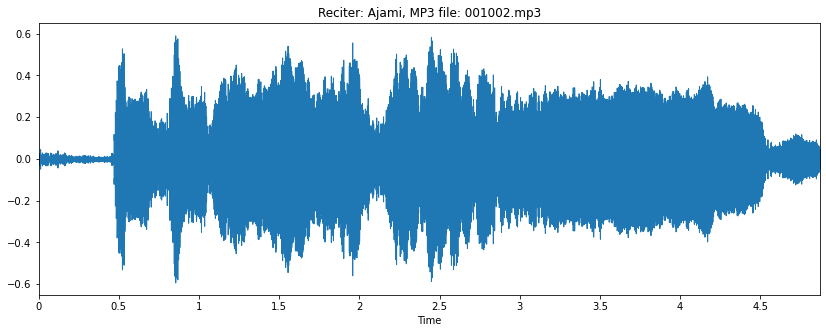

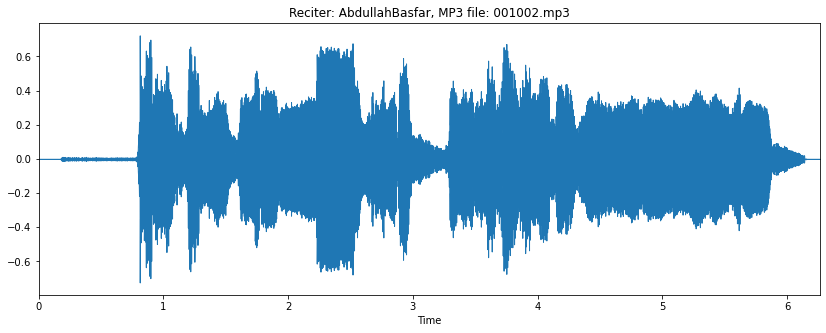

In [12]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file(my_reciter, my_mp3_file)

# Audio Feature Extraction
Audio signals consist of many features. We need to extract the features relevant to the problem at hand so we can analyze them. Let's take a look at few features in more detail.

We can tranform the audio signal from time-domain into frequency-domain using Fourier Transform to get frequency-based features (or "spectral" features). Here are some spectral features of interest.

## 1. Mel-spectogram
Mel-spectogram is a visual representation of spectrum of frequencies over time. A regular spectogram is squared magnitude of the Short Term Fourier Transform (STFT) of the audio signal. This regular spectogram is squashed using mel scale to convert the audio frequencies into something a human is more able to understand. 

In [13]:
def plot_audio_file_melspect(reciter, mp3_file):
    n_fft = 2048
    hop_length = 512
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    my_title = "Melspectogram for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    y , sr = librosa.load(file_name)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length)
    spect = librosa.power_to_db(spect, ref=np.max)
    print(type(y), type(sr))
    print(y.shape, sr)
    print(spect.shape)
    plt.figure(figsize=(15, 7))
    plt.title(my_title)
    librosa.display.specshow(spect.T, sr=sr, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()


<class 'numpy.ndarray'> <class 'int'>
(107448,) 22050
(128, 210)
<class 'numpy.ndarray'> <class 'int'>
(138122,) 22050
(128, 270)


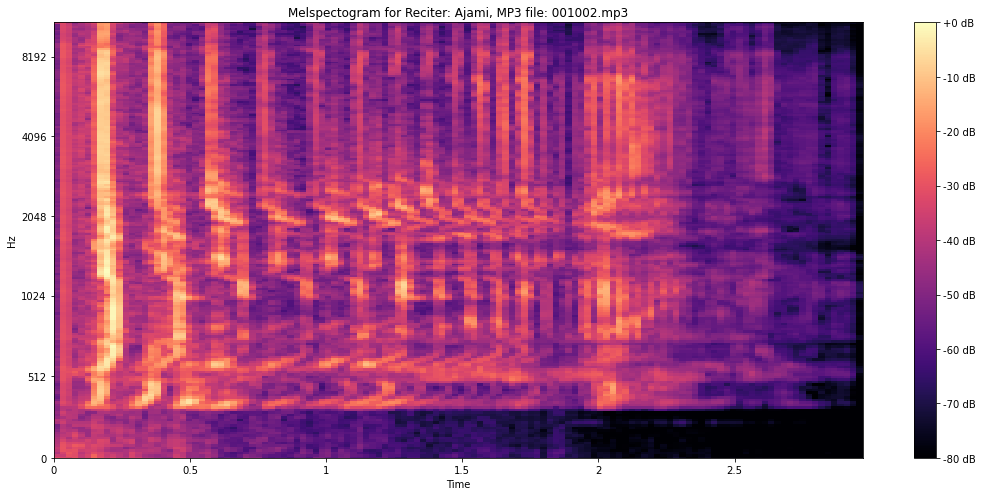

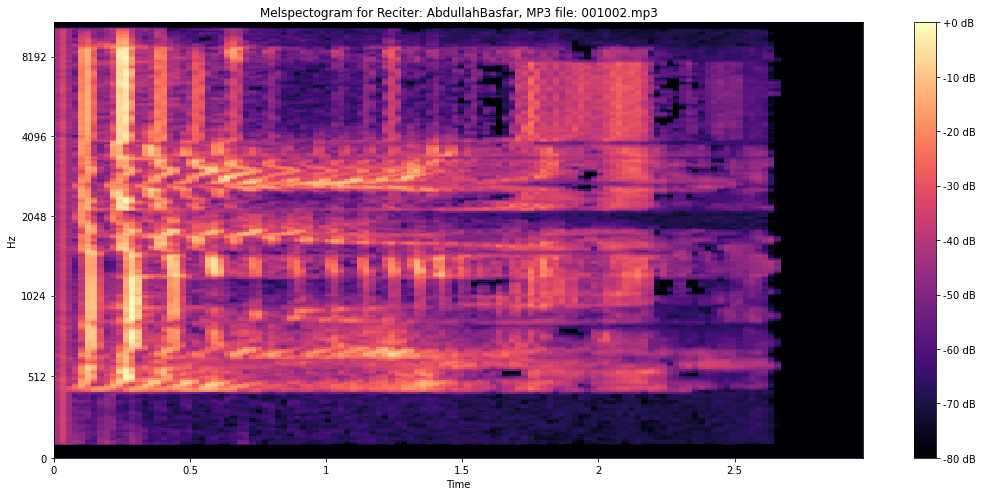

In [14]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_melspect(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_melspect(my_reciter, my_mp3_file)

## 2. Mel-Frequency Cepstral Coefficients(MFCCs)
The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

In [15]:
def plot_audio_file_mfccs(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    my_title = "MFCCs for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    y , sr = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y, sr=sr)
    print(type(y), type(sr))
    print(y.shape, sr)
    print(mfccs.shape)
    plt.figure(figsize=(15, 7))
    plt.title(my_title)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')


<class 'numpy.ndarray'> <class 'int'>
(107448,) 22050
(20, 210)
<class 'numpy.ndarray'> <class 'int'>
(138122,) 22050
(20, 270)


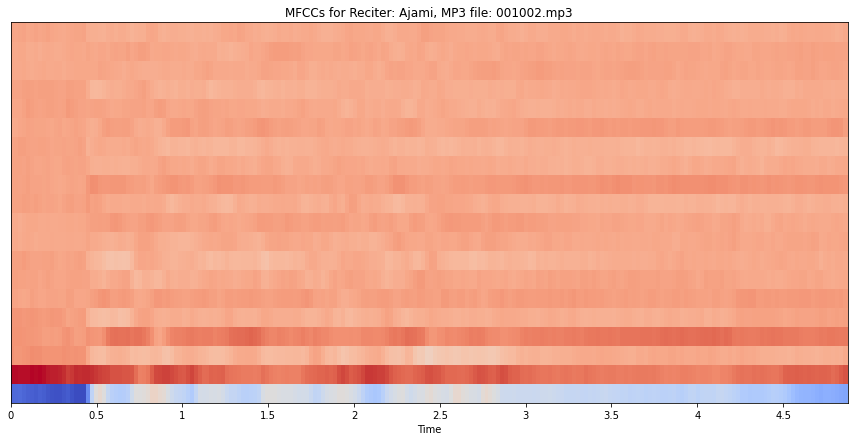

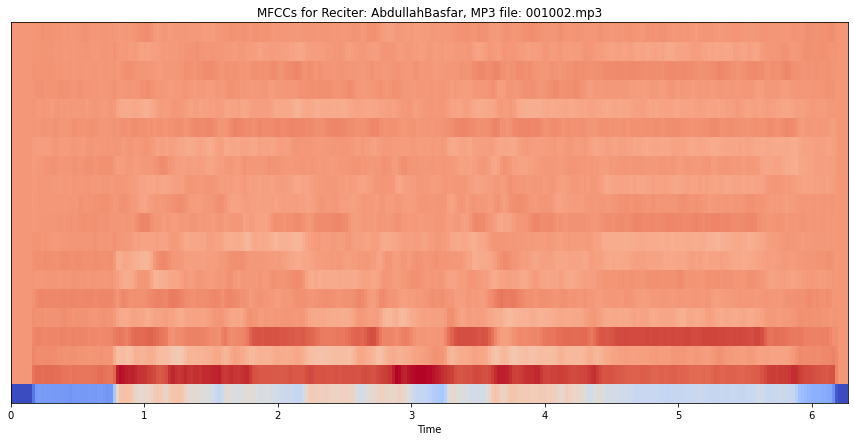

In [16]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_mfccs(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_mfccs(my_reciter, my_mp3_file)

## 3. Zero-Crossing Rate
A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.


In [17]:
def plot_audio_file_zcr(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5))
    my_title = "Zero-Crossing Rate for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    librosa.display.waveplot(y, sr=sr)
    
    # Zooming in
    n0 = 8000
    n1 = 8100
    plt.figure(figsize=(14, 5))
    my_title = "Zero-Crossing Rate (ZOOMED IN) for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    plt.plot(y[n0:n1])
    plt.grid()

    # Number of crossings
    zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
    print(my_title)
    print(sum(zero_crossings))
    

Zero-Crossing Rate (ZOOMED IN) for Reciter: Ajami, MP3 file: 001002.mp3
7
Zero-Crossing Rate (ZOOMED IN) for Reciter: AbdullahBasfar, MP3 file: 001002.mp3
15


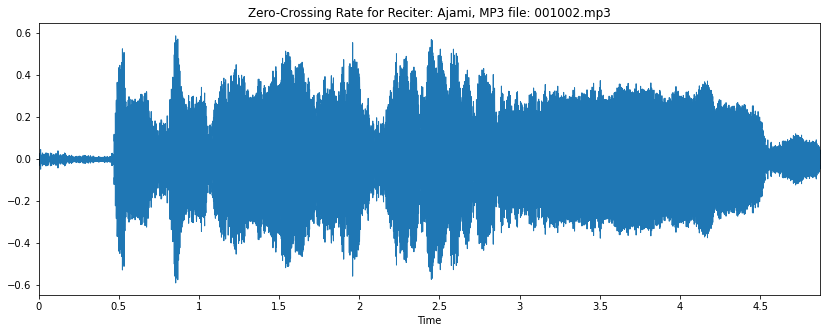

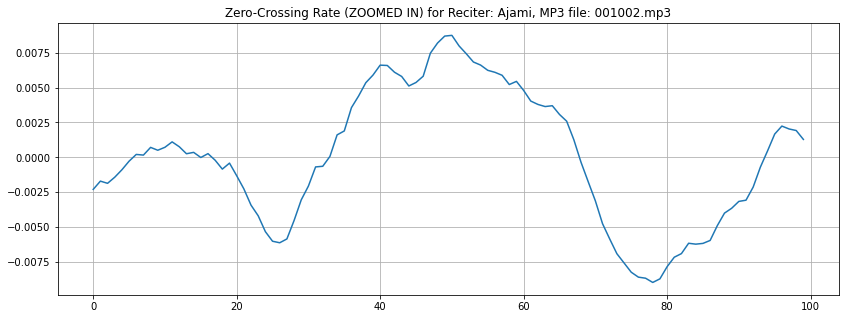

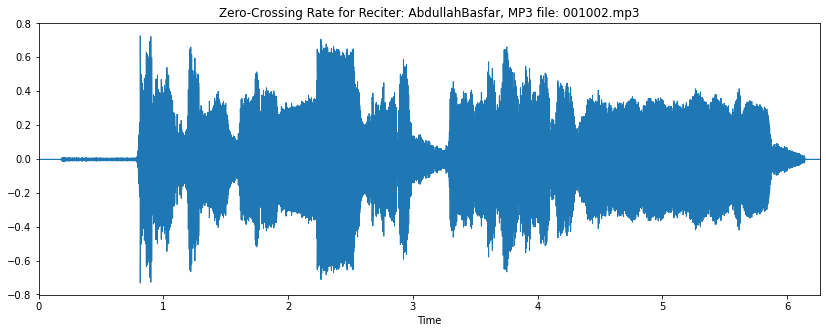

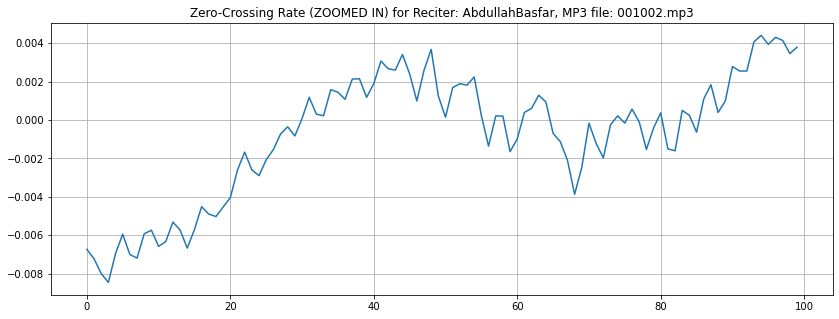

In [18]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_zcr(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_zcr(my_reciter, my_mp3_file)

## 4. Spectral Centroid
The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. 

In [19]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
def plot_audio_file_spec_centr(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5)) 
    spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]
    # Computing the time variable for visualization
    #plt.figure(figsize=(12, 4))
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    my_title = "Spectral Centroid for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    #Plotting the Spectral Centroid along the waveform
    librosa.display.waveplot(y, sr=sr, alpha=0.4)
    # Normalising the spectral centroid for visualisation
    plt.plot(t, normalize(spectral_centroids), color='g')
    

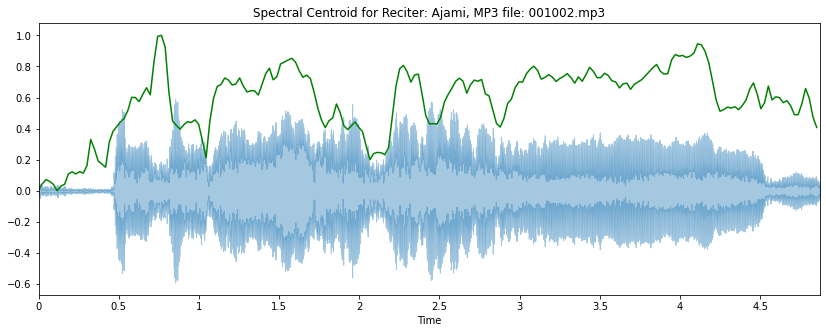

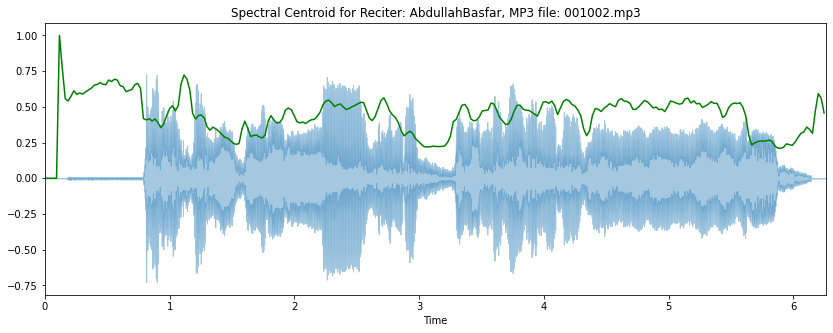

In [20]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_spec_centr(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_spec_centr(my_reciter, my_mp3_file)

## 5. Spectral Rolloff
This is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. To obtain it, we have to calculate the fraction of bins in the power spectrum where 85% of its power is at lower frequencies.

In [21]:
def plot_audio_file_spec_rolloff(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5)) 
    spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    my_title = "Spectral Rolloff for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    librosa.display.waveplot(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    

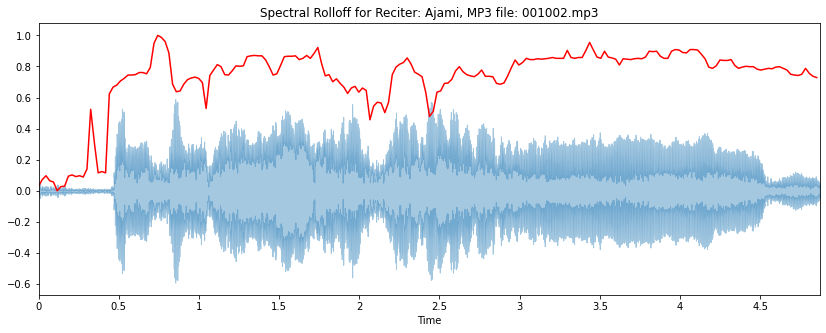

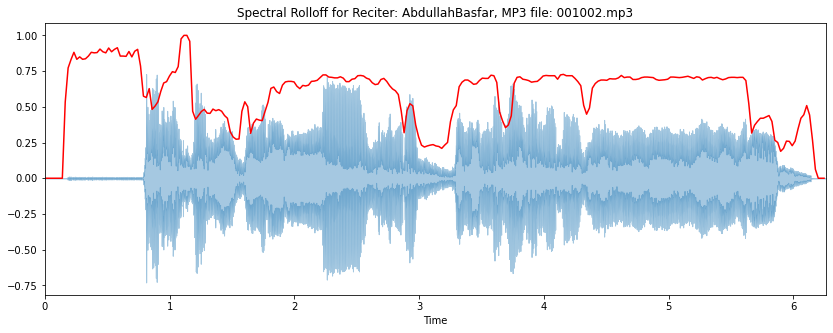

In [22]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_spec_rolloff(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_spec_rolloff(my_reciter, my_mp3_file)

## 6. Chroma Frequencies
Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave. Let's see how they look for voice audio.

In [23]:
def plot_audio_file_chroma(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5)) 
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hop_length)
    my_title = "Chroma for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


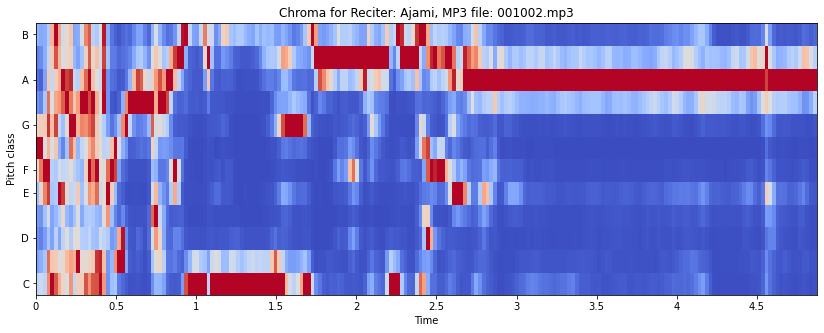

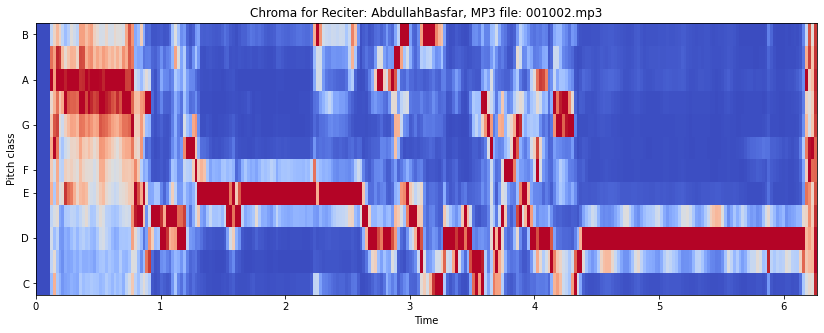

In [24]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_chroma(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_chroma(my_reciter, my_mp3_file)

## 7. Spectral Bandwidth
The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.

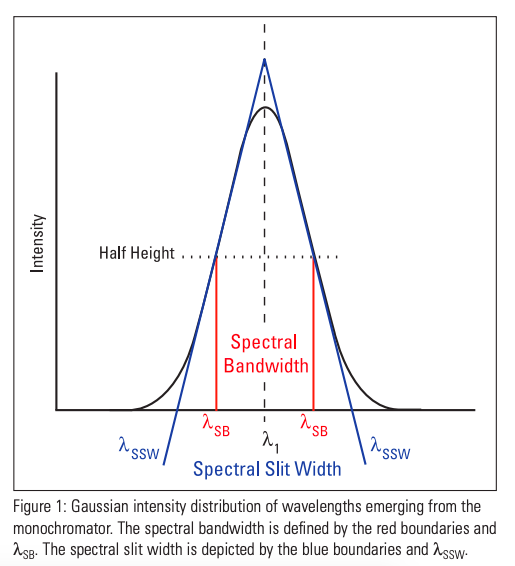

In [25]:
def plot_audio_file_spec_bw(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5)) 
    #spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y+0.01, sr=sr, p=4)[0]
    frames = range(len(spectral_bandwidth_2))
    t = librosa.frames_to_time(frames)
    librosa.display.waveplot(y, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_bandwidth_2), color='r')
    plt.plot(t, normalize(spectral_bandwidth_3), color='g')
    plt.plot(t, normalize(spectral_bandwidth_4), color='y')
    plt.legend(('p = 2', 'p = 3', 'p = 4'))
    my_title = "Spectral Bandwidth for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    

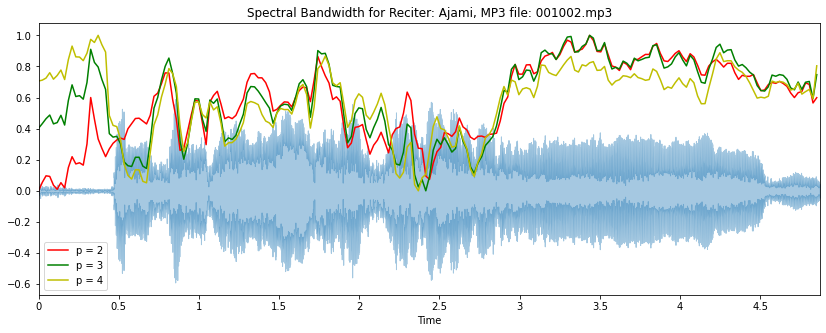

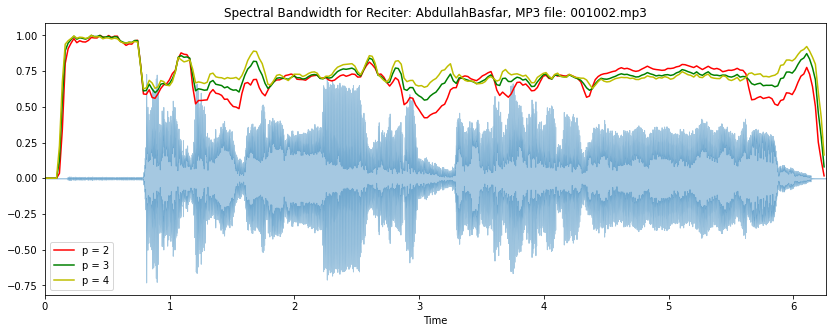

In [26]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_spec_bw(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_spec_bw(my_reciter, my_mp3_file)

## 8. Spectral Contrast
Spectral contrast considers the spectral peak, the spectral valley, and their difference in each frequency subband. 

In [27]:
def plot_audio_file_spec_contr(reciter, mp3_file):
    file_name = os.path.join(audio_data_dir, my_reciter, my_mp3_file)
    y , sr = librosa.load(file_name)

    plt.figure(figsize=(14, 5)) 
    hop_length=512
    spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr)
    #plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
    my_title = "Spectral Contrast for Reciter: " + my_reciter + ", MP3 file: " + mp3_file
    plt.title(my_title)
    librosa.display.specshow(normalize(spectral_contrast, axis=1), x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')


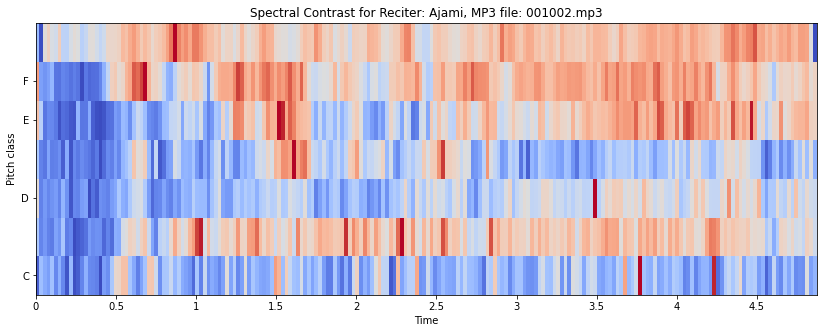

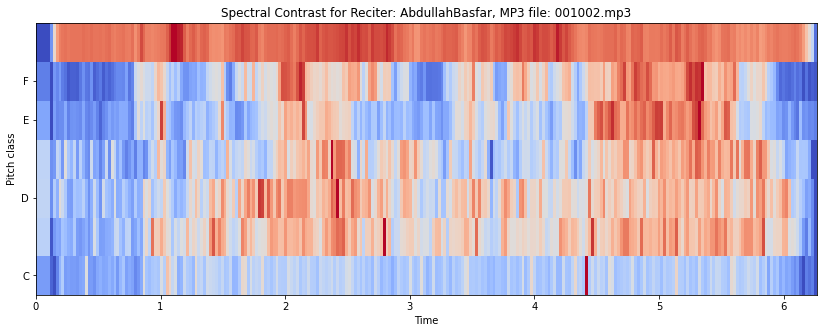

In [28]:
# Load an audio file and plot it
my_reciter = 'Ajami'
my_mp3_file = '001002.mp3'
plot_audio_file_spec_contr(my_reciter, my_mp3_file)

# Load an audio file and plot it
my_reciter = 'AbdullahBasfar'
plot_audio_file_spec_contr(my_reciter, my_mp3_file)

In [29]:
# Look at all the audio durations
df['Duration'].describe()

count    40.000000
mean      6.388593
std       3.157872
min       2.721655
25%       4.629932
50%       5.524898
75%       6.511020
max      16.770612
Name: Duration, dtype: float64

In [30]:
# Max duration
duration_max = df['Duration'].max()
print(duration_max)

16.770612244897958
